In [114]:
# Libraries
import os
import math
import numpy as np 
import time
import sys
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)
import torch.nn as nn
import torch.nn.functional as F


Using torch 2.0.0+cu117


In [115]:
# Device and seed
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(42) # Setting the seed
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(device)

cpu


# Data

In [128]:
sys.path.append('/home/sebacastillo/neuralnets/')
from src.utils import get_project_root
root = get_project_root()
import torch.utils.data as data

In [129]:
class Dataset(data.Dataset):

    def __init__(self, filename):        
        #------------------------------------
        # LECTURA DE LOS DATOS
        data = pd.read_csv(filename, header=None).to_numpy() # Levanta los datos en formato numpy
        
        #------------------------------------
        # INSERTAMOS COLUMNA DEL "BIAS"
        #bias = -np.ones((len(data), 1))
        #data = np.concatenate((bias, data), axis=1)  # Insertamos el "bias" en la primera columna
        
        #------------------------------------
        # ALEATORIZO LOS PATRONES (filas)
        idxs = np.arange(len(data))  # Genero un vector de índices
        np.random.shuffle(idxs)
        data = data[idxs,:]
        
        #------------------------------------
        # SEPARO LOS DATOS
        self.data = data[:,:-1].astype(np.float32)
        self.label = data[:,-1].astype(np.float32)  # La clase está en la última columna

    #===================================================
    def __len__(self):
        '''
        Devuelve el número de patrones en el dataset.
        '''
        return len(self.data)

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [130]:
dataset_train = Dataset(str(root)+'/data/data/XOR_trn.csv')
dataset_test = Dataset(str(root)+'/data/data/XOR_tst.csv')

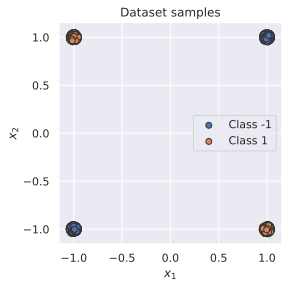

In [131]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_neg1 = data[label == -1]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_neg1[:,0], data_neg1[:,1], edgecolor="#333", label="Class -1")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
visualize_samples(dataset_train.data, dataset_train.label)
plt.show()

# DNN Model

In [132]:
class SimpleClassifier(nn.Module):

    def __init__(self, n_features, n_outputs):
        '''
        Esta función inicializa/construye el perceptrón.
        n_features: features de cada patrón (2 para OR y XOR)
        n_outputs: cantidad de salidas esperadas.
        '''
        
        super().__init__()
        
        self.n_features = n_features
        self.n_outputs = n_outputs
        
        self.fc = nn.Linear(self.n_features, self.n_outputs, bias=True)
        
        self.tanh = nn.Tanh()

    def forward(self, x):
        '''
        Esta función realiza la pasada hacia adelante.
        '''
        # Calculo salida lineal
        y = self.fc(x)
        
        # Aplico función no lineal
        y = self.tanh(y)

        return y

In [133]:
loss_module = nn.MSELoss(reduction='mean').to(device)

In [134]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train() 
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()

### Experiment

In [135]:
# Parametros del experimento
batch_size = 30
learning_rate = 0.5

#=============================================================
# Construimos dataloaders para entrenamiento 
#=============================================================
train_data = data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
#=============================================
# Inicializamos el modelo
#=============================================
model = SimpleClassifier(n_features=2, n_outputs=1)
model.to(device)
#=============================================
# Definimos la función de LOSS a utilizar
#=============================================
loss_function = nn.MSELoss(reduction='mean').to(device)
#=============================================
# Definimos el optimizador a utilizar
# >>> 3er paso del bacpropagation
#=============================================
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0) #0.9

In [136]:
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

### Evaluation

In [137]:
test_data_loader = data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False) 

In [138]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.
    
    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            
            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1
            
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [139]:
eval_model(model, test_data_loader)

Accuracy of the model: 18.00%


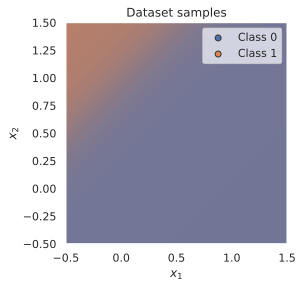

In [140]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset_test.data, dataset_test.label)
plt.show()